In [85]:
# Import packages for data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for data modeling
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

# This module lets us save our models once we fit them.
import pickle

### Data Conection to S3

In [86]:
#Import packages for data connection to S3
import boto3
from io import StringIO

In [87]:
# Path to local CSV file
file_path = r'c:\Users\Usuario\Downloads\bucketcredentials.csv'
credentials_df = pd.read_csv(file_path)

aws_access_key_id = credentials_df['aws_access_key_id'].iloc[0]
aws_secret_access_key = credentials_df['aws_secret_access_key'].iloc[0]
bucket_name = credentials_df['bucket_name'].iloc[0]

input_file_key = 'SourceDataSet/bank_data_train.csv'
output_file_key = 'TargetDataSet/clean_bankchurn.csv'

In [88]:
# Create an S3 client
s3_client = boto3.client('s3', aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_access_key)

In [89]:
# Read the CSV file from S3 into a DataFrame
obj = s3_client.get_object(Bucket=bucket_name, Key=input_file_key)
df = pd.read_csv(obj['Body'])

In [90]:
# Read in the data
#df = pd.read_csv('bank_data_train.csv')

In [91]:
df.head()

,ID,CR_PROD_CNT_IL,AMOUNT_RUB_CLO_PRC,PRC_ACCEPTS_A_EMAIL_LINK,APP_REGISTR_RGN_CODE,PRC_ACCEPTS_A_POS,PRC_ACCEPTS_A_TK,TURNOVER_DYNAMIC_IL_1M,CNT_TRAN_AUT_TENDENCY1M,SUM_TRAN_AUT_TENDENCY1M,AMOUNT_RUB_SUP_PRC,PRC_ACCEPTS_A_AMOBILE,SUM_TRAN_AUT_TENDENCY3M,CLNT_TRUST_RELATION,PRC_ACCEPTS_TK,PRC_ACCEPTS_A_MTP,REST_DYNAMIC_FDEP_1M,CNT_TRAN_AUT_TENDENCY3M,CNT_ACCEPTS_TK,APP_MARITAL_STATUS,REST_DYNAMIC_SAVE_3M,CR_PROD_CNT_VCU,REST_AVG_CUR,CNT_TRAN_MED_TENDENCY1M,APP_KIND_OF_PROP_HABITATION,CLNT_JOB_POSITION_TYPE,AMOUNT_RUB_NAS_PRC,CLNT_JOB_POSITION,APP_DRIVING_LICENSE,TRANS_COUNT_SUP_PRC,APP_EDUCATION,CNT_TRAN_CLO_TENDENCY1M,SUM_TRAN_MED_TENDENCY1M,PRC_ACCEPTS_A_ATM,PRC_ACCEPTS_MTP,TRANS_COUNT_NAS_PRC,APP_TRAVEL_PASS,CNT_ACCEPTS_MTP,CR_PROD_CNT_TOVR,APP_CAR,CR_PROD_CNT_PIL,SUM_TRAN_CLO_TENDENCY1M,APP_POSITION_TYPE,TURNOVER_CC,TRANS_COUNT_ATM_PRC,AMOUNT_RUB_ATM_PRC,TURNOVER_PAYM,AGE,CNT_TRAN_MED_TENDENCY3M,CR_PROD_CNT_CC,SUM_TRAN_MED_TENDENCY3M,REST_DYNAMIC_FDEP_3M,REST_DYNAMIC_IL_1M,APP_EMP_TYPE,SUM_TRAN_CLO_TENDENCY3M,LDEAL_TENOR_MAX,LDEAL_YQZ_CHRG,CR_PROD_CNT_CCFP,DEAL_YQZ_IR_MAX,LDEAL_YQZ_COM,DEAL_YQZ_IR_MIN,CNT_TRAN_CLO_TENDENCY3M,REST_DYNAMIC_CUR_1M,REST_AVG_PAYM,LDEAL_TENOR_MIN,LDEAL_AMT_MONTH,APP_COMP_TYPE,LDEAL_GRACE_DAYS_PCT_MED,REST_DYNAMIC_CUR_3M,CNT_TRAN_SUP_TENDENCY3M,TURNOVER_DYNAMIC_CUR_1M,REST_DYNAMIC_PAYM_3M,SUM_TRAN_SUP_TENDENCY3M,REST_DYNAMIC_IL_3M,CNT_TRAN_ATM_TENDENCY3M,CNT_TRAN_ATM_TENDENCY1M,TURNOVER_DYNAMIC_IL_3M,SUM_TRAN_ATM_TENDENCY3M,DEAL_GRACE_DAYS_ACC_S1X1,AVG_PCT_MONTH_TO_PCLOSE,DEAL_YWZ_IR_MIN,SUM_TRAN_SUP_TENDENCY1M,DEAL_YWZ_IR_MAX,SUM_TRAN_ATM_TENDENCY1M,REST_DYNAMIC_PAYM_1M,CNT_TRAN_SUP_TENDENCY1M,DEAL_GRACE_DAYS_ACC_AVG,TURNOVER_DYNAMIC_CUR_3M,PACK,MAX_PCLOSE_DATE,LDEAL_YQZ_PC,CLNT_SETUP_TENOR,DEAL_GRACE_DAYS_ACC_MAX,TURNOVER_DYNAMIC_PAYM_3M,LDEAL_DELINQ_PER_MAXYQZ,TURNOVER_DYNAMIC_PAYM_1M,CLNT_SALARY_VALUE,TRANS_AMOUNT_TENDENCY3M,MED_DEBT_PRC_YQZ,TRANS_CNT_TENDENCY3M,LDEAL_USED_AMT_AVG_YQZ,REST_DYNAMIC_CC_1M,LDEAL_USED_AMT_AVG_YWZ,TURNOVER_DYNAMIC_CC_1M,AVG_PCT_DEBT_TO_DEAL_AMT,LDEAL_ACT_DAYS_ACC_PCT_AVG,REST_DYNAMIC_CC_3M,MED_DEBT_PRC_YWZ,LDEAL_ACT_DAYS_PCT_TR3,LDEAL_ACT_DAYS_PCT_AAVG,LDEAL_DELINQ_PER_MAXYWZ,TURNOVER_DYNAMIC_CC_3M,LDEAL_ACT_DAYS_PCT_TR,LDEAL_ACT_DAYS_PCT_TR4,LDEAL_ACT_DAYS_PCT_CURR,TARGET
0,146841,0,0.000000,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.541683,0,156067.339800,NaN,NaN,NaN,0.0,начальник отдела,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,0,NaN,NaN,0.0,1.000000,1.000000,0.0,660,NaN,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.134651,0.0,NaN,NaN,NaN,0.0,0.474134,NaN,0.131910,0.0,NaN,0.0,0.406780,0.101695,0.0,0.483032,NaN,NaN,NaN,NaN,NaN,0.134634,0.0,NaN,NaN,0.442285,K01,NaN,NaN,1.593023,NaN,0.0,NaN,0.0,NaN,0.483032,NaN,0.406780,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0
1,146842,0,0.041033,NaN,NaN,NaN,NaN,0.0,0.166667,0.186107,0.244678,NaN,0.670968,NaN,NaN,NaN,0.0,0.666667,NaN,NaN,0.000000,0,4278.845817,NaN,NaN,NaN,0.0,NaN,NaN,0.454545,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,0,NaN,NaN,0.0,0.109091,0.410691,0.0,552,NaN,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.239365,0.0,NaN,NaN,NaN,0.0,0.384264,0.6,0.101934,0.0,0.510712,0.0,0.333333,0.166667,0.0,0.200000,NaN,NaN,NaN,0.309799,NaN,0.133333,0.0,0.24,NaN,0.515876,102,NaN,NaN,1.587647,NaN,0.0,NaN,0.0,NaN,0.394340,NaN,0.545455,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0
2,146843,0,0.006915,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.000000,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,0.000000,0,112837.062800,NaN,NaN,NaN,0.0,ГЕНЕРАЛЬНЫЙ ДИРЕКТОР,NaN,0.000000,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0,NaN,0,NaN,NaN,0.0,0.810811,0.925140,0.0,420,NaN,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.084341,0.0,NaN,NaN,NaN,0.0,0.336136,NaN,0.121041,0.0,NaN,0.0,0.366667,0.133333,0.0,0.431656,NaN,NaN,NaN,NaN,NaN,0.063129,0.0,NaN,NaN,0.522833,102,NaN,NaN,1.587647,NaN,0.0,NaN,0.0,NaN,0.399342,NaN,0.297297,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0
3,146844,0,0.00

## Data cleaning and pre-processing

### 1. Changing to lowercase column names to improve readability.

In [92]:
# Loop through each column name
for col in df.columns:
  # Check if the column name is uppercase
  if col.isupper():
    # Rename the column to lowercase
    df.rename(columns={col: col.lower()}, inplace=True)

df.columns

Index(['id', 'cr_prod_cnt_il', 'amount_rub_clo_prc',
       'prc_accepts_a_email_link', 'app_registr_rgn_code', 'prc_accepts_a_pos',
       'prc_accepts_a_tk', 'turnover_dynamic_il_1m', 'cnt_tran_aut_tendency1m',
       'sum_tran_aut_tendency1m',
       ...
       'rest_dynamic_cc_3m', 'med_debt_prc_ywz', 'ldeal_act_days_pct_tr3',
       'ldeal_act_days_pct_aavg', 'ldeal_delinq_per_maxywz',
       'turnover_dynamic_cc_3m', 'ldeal_act_days_pct_tr',
       'ldeal_act_days_pct_tr4', 'ldeal_act_days_pct_curr', 'target'],
      dtype='object', length=116)

>Using describe function to understand better the data

In [93]:
df.describe(include='all')

,id,cr_prod_cnt_il,amount_rub_clo_prc,prc_accepts_a_email_link,app_registr_rgn_code,prc_accepts_a_pos,prc_accepts_a_tk,turnover_dynamic_il_1m,cnt_tran_aut_tendency1m,sum_tran_aut_tendency1m,amount_rub_sup_prc,prc_accepts_a_amobile,sum_tran_aut_tendency3m,clnt_trust_relation,prc_accepts_tk,prc_accepts_a_mtp,rest_dynamic_fdep_1m,cnt_tran_aut_tendency3m,cnt_accepts_tk,app_marital_status,rest_dynamic_save_3m,cr_prod_cnt_vcu,rest_avg_cur,cnt_tran_med_tendency1m,app_kind_of_prop_habitation,clnt_job_position_type,amount_rub_nas_prc,clnt_job_position,app_driving_license,trans_count_sup_prc,app_education,cnt_tran_clo_tendency1m,sum_tran_med_tendency1m,prc_accepts_a_atm,prc_accepts_mtp,trans_count_nas_prc,app_travel_pass,cnt_accepts_mtp,cr_prod_cnt_tovr,app_car,cr_prod_cnt_pil,sum_tran_clo_tendency1m,app_position_type,turnover_cc,trans_count_atm_prc,amount_rub_atm_prc,turnover_paym,age,cnt_tran_med_tendency3m,cr_prod_cnt_cc,sum_tran_med_tendency3m,rest_dynamic_fdep_3m,rest_dynamic_il_1m,app_emp_type,sum_tran_clo_tendency3m,ldeal_tenor_max,ldeal_yqz_chrg,cr_prod_cnt_ccfp,deal_yqz_ir_max,ldeal_yqz_com,deal_yqz_ir_min,cnt_tran_clo_tendency3m,rest_dynamic_cur_1m,rest_avg_paym,ldeal_tenor_min,ldeal_amt_month,app_comp_type,ldeal_grace_days_pct_med,rest_dynamic_cur_3m,cnt_tran_sup_tendency3m,turnover_dynamic_cur_1m,rest_dynamic_paym_3m,sum_tran_sup_tendency3m,rest_dynamic_il_3m,cnt_tran_atm_tendency3m,cnt_tran_atm_tendency1m,turnover_dynamic_il_3m,sum_tran_atm_tendency3m,deal_grace_days_acc_s1x1,avg_pct_month_to_pclose,deal_ywz_ir_min,sum_tran_sup_tendency1m,deal_ywz_ir_max,sum_tran_atm_tendency1m,rest_dynamic_paym_1m,cnt_tran_sup_tendency1m,deal_grace_days_acc_avg,turnover_dynamic_cur_3m,pack,max_pclose_date,ldeal_yqz_pc,clnt_setup_tenor,deal_grace_days_acc_max,turnover_dynamic_paym_3m,ldeal_delinq_per_maxyqz,turnover_dynamic_paym_1m,clnt_salary_value,trans_amount_tendency3m,med_debt_prc_yqz,trans_cnt_tendency3m,ldeal_used_amt_avg_yqz,rest_dynamic_cc_1m,ldeal_used_amt_avg_ywz,turnover_dynamic_cc_1m,avg_pct_debt_to_deal_amt,ldeal_act_days_acc_pct_avg,rest_dynamic_cc_3m,med_debt_prc_ywz,ldeal_act_days_pct_tr3,ldeal_act_days_pct_aavg,ldeal_delinq_per_maxywz,turnover_dynamic_cc_3m,ldeal_act_days_pct_tr,ldeal_act_days_pct_tr4,ldeal_act_days_pct_curr,target
count,355190.000000,355190.000000,316867.000000,155163.0,60550.000000,155163.0,155163.0,355190.000000,77112.000000,77112.000000,316867.000000,155163.0,111052.000000,69421,155163.0,155163.0,355190.000000,111052.000000,155163.0,68234,355190.000000,355190.000000,3.551900e+05,68967.000000,59361,44781,316867.000000,210811,57257,316867.000000,68104,66296.000000,68967.000000,155163.0,155163.0,316867.000000,57257,155163.0,355190.000000,57256,355190.000000,6.629600e+04,60545,3.551900e+05,316867.000000,316867.000000,3.551900e+05,355190.000000,115877.000000,355190.000000,115877.000000,355190.000000,355190.000000,67362,114898.000000,8001.000000,1.241000e+03,355190.000000,8001.000000,1.240000e+03,8001.000000,114898.000000,355190.000000,3.551900e+05,8001.000000,1.888000e+03,67362,355190.000000,355190.000000,198718.000000,355190.000000,355190.000000,198718.000000,355190.000000,255595.000000,205874.000000,355190.000000,255595.000000,70449.000000,1628.000000,95713.000000,155995.000000,95713.000000,205874.000000,355190.000000,155995.000000,69433.000000,355190.000000,355190,1881.000000,2.808000e+03,355190.000000,69433.000000,355190.000000,8001.000000,355190.000000,712.000000,303194.000000,8001.000000,303194.000000,8001.000000,355190.000000,95713.000000,355190.000000,1888.000000,93448.000000,355190.000000,95713.000000,93448.000000,98175.000000,95713.000000,355190.000000,93448.000000,93448.000000,93448.000000,355190.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,NaN,NaN,NaN,NaN,NaN,13,NaN,NaN,NaN,NaN,5,4,NaN,19552,2,NaN,17,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,2,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

Notice that the prc_accepts_a_tk have values nan and 0.  

In [94]:
df['prc_accepts_a_tk'].unique()

array([nan,  0.])

>Now, let's create a quick function to get the column names of those with values as "nan" and "0."

In [95]:
# Identify the columns with only nan and zero values

def get_zero_and_nan_columns(df):
    zero_and_nan_columns = []
    for col in df.columns:
        if df[col].nunique() == 1:
            zero_and_nan_columns.append(col)
    return zero_and_nan_columns

zero_and_nan_columns = get_zero_and_nan_columns(df)
zero_and_nan_columns

['prc_accepts_a_email_link',
 'prc_accepts_a_pos',
 'prc_accepts_a_tk',
 'prc_accepts_a_amobile',
 'prc_accepts_tk',
 'prc_accepts_a_mtp',
 'cnt_accepts_tk',
 'prc_accepts_a_atm',
 'prc_accepts_mtp',
 'cnt_accepts_mtp']

>Having 10 columns containing only "nan" and "0." can negatively impact our machine learning model. These values offer no meaningful distinction between data points, making it difficult for the model to learn patterns and relationships within your data. This can lead to poor model performance and inaccurate predictions. 

### 2. Dropping columns with this "nan" and "0." values.

In [96]:
# Dropping columns zero_and_nan_columns 
df = df.drop(columns=zero_and_nan_columns)
df.shape

(355190, 106)

>We also find two columns with values in Rusian language. Machine learning models typically struggle with non-numeric data, especially different languages.  Translating the values to English creates a common language the model can understand. 

In [97]:
df['clnt_trust_relation'].unique()

array([nan, 'MOTHER', 'BROTHER', 'FRIEND', 'SISTER', 'OTHER', 'RELATIVE',
       'DAUGHTER', 'SON', 'FATHER', 'Близкий ро', 'Друг', 'Отец',
       'Сестра', 'Сын', 'Мать', 'Муж', 'Брат', 'мать', 'Дальний ро',
       'Дочь', 'Жена'], dtype=object)

In [98]:
df['clnt_job_position'].unique()

array(['начальник отдела', nan, 'ГЕНЕРАЛЬНЫЙ ДИРЕКТОР', ...,
       'Эксперт контакт Центра', 'ПРОХЛДЧИК',
       'ХУДОЖНИК КОМПЬЮТЕРНОЙ ГРАФИКИ'], dtype=object)

### 3. Translating Rusian Values

After creating a dictionary with the rusian values we applied a function to translate those values:

In [99]:
def replace_russian_values(df, columns_to_translate, russian_to_english_dict):
  
  # Create a copy to avoid modifying the original DataFrame
  replaced_df = df.copy()

  # Replace values in specified columns
  for col in columns_to_translate:
    replaced_df[col] = replaced_df[col].replace(russian_to_english_dict)

  return replaced_df

# Russian to English dictionary (replace with your actual dictionary)
russian_to_english_dict = {
    "MOTHER": "mother",
    "BROTHER": "brother",
    "FRIEND": "friend",
    "SISTER": "sister",
    "OTHER": "other",
    "RELATIVE": "relative",
    "DAUGHTER": "daughter",
    "SON": "son",
    "FATHER": "father",
    "Близкий ро": "close ro",
    "Друг": "friend",
    "Отец": "father",
    "Сестра": "sister",
    "Сын": "son",
    "Мать": "mother",
    "Муж": "husband",
    "Брат": "brother",
    "мать": "mother",
    "Дальний ро": "far ro",
    "Дочь": "daughter",
    "Жена": "wife",
    "начальник отдела": "department head",
    "ГЕНЕРАЛЬНЫЙ ДИРЕКТОР": "ceo",
    "Эксперт контакт Центра": "expert contact center",
    "ПРОХЛДЧИК": "cool",
    "ХУДОЖНИК КОМПЬЮТЕРНОЙ ГРАФИКИ": "computer graphics artist",
    
}

# Columns to replace (replace with your actual column names)
columns_to_translate = ['clnt_trust_relation', 'clnt_job_position']

# Replace the specified columns
df = replace_russian_values(df, columns_to_translate, russian_to_english_dict)


>Checking the unique values in the translated columns:

In [100]:
df['clnt_trust_relation'].unique()

array([nan, 'mother', 'brother', 'friend', 'sister', 'other', 'relative',
       'daughter', 'son', 'father', 'close ro', 'husband', 'far ro',
       'wife'], dtype=object)

In [101]:
df['clnt_job_position'].unique()

array(['department head', nan, 'ceo', ..., 'expert contact center',
       'cool', 'computer graphics artist'], dtype=object)

### 4. Managing null values

In [102]:
# Counting null values

def count_nulls(df):
    for column in df.columns:
        print(f'Nulls in column {column}:', df[column].isnull().sum())
        
count_nulls(df)

Nulls in column id: 0
Nulls in column cr_prod_cnt_il: 0
Nulls in column amount_rub_clo_prc: 38323
Nulls in column app_registr_rgn_code: 294640
Nulls in column turnover_dynamic_il_1m: 0
Nulls in column cnt_tran_aut_tendency1m: 278078
Nulls in column sum_tran_aut_tendency1m: 278078
Nulls in column amount_rub_sup_prc: 38323
Nulls in column sum_tran_aut_tendency3m: 244138
Nulls in column clnt_trust_relation: 285769
Nulls in column rest_dynamic_fdep_1m: 0
Nulls in column cnt_tran_aut_tendency3m: 244138
Nulls in column app_marital_status: 286956
Nulls in column rest_dynamic_save_3m: 0
Nulls in column cr_prod_cnt_vcu: 0
Nulls in column rest_avg_cur: 0
Nulls in column cnt_tran_med_tendency1m: 286223
Nulls in column app_kind_of_prop_habitation: 295829
Nulls in column clnt_job_position_type: 310409
Nulls in column amount_rub_nas_prc: 38323
Nulls in column clnt_job_position: 144379
Nulls in column app_driving_license: 297933
Nulls in column trans_count_sup_prc: 38323
Nulls in column app_education

>We've identified several columns with potentially high numbers of missing values. To assess their relevance, let's calculate the percentage of null values in each column and sort them in descending order. This will reveal which columns have the most missing data.

In [103]:
def get_null_value_counts(df):
  
  null_counts = df.isna().sum()
  null_counts_df = pd.DataFrame({'column_name': null_counts.index, 'null_count': null_counts.values})
  
  return null_counts_df

# Get null value counts
null_counts_df = get_null_value_counts(df)
null_counts_df = null_counts_df.sort_values(by='null_count', ascending=False)
null_counts_df['pcnt_null'] = null_counts_df['null_count'] / df.shape[0]

In [104]:
null_counts_df.head(10)

,column_name,null_count,pcnt_null
86,clnt_salary_value,354478,0.997995
49,ldeal_yqz_com,353950,0.996509
46,ldeal_yqz_chrg,353949,0.996506
69,avg_pct_month_to_pclose,353562,0.995417
79,max_pclose_date,353309,0.994704
94,avg_pct_debt_to_deal_amt,353302,0.994685
55,ldeal_amt_month,353302,0.994685
80,ldeal_yqz_pc,352382,0.992094
45,ldeal_tenor_max,347189,0.977474
50,deal_yqz_ir_min,347189,0.977474


> Our initial analysis revealed 72 columns with a significant amount of missing data, hovering around 30% null values. To improve data quality and model performance, we'll focus on removing columns with extreme levels of missingness. We'll establish a threshold of 70% null values. Any column exceeding this threshold will be dropped from the dataset. This approach ensures we retain columns with a reasonable amount of data for analysis while eliminating those unlikely to contribute meaningfully due to excessive missing information.

In [105]:
def drop_irrelevant_columns(df, null_value_threshold=50000):
 
  null_counts = df.isnull().sum()
  columns_to_drop = null_counts[null_counts > null_value_threshold].index.tolist()
  return df.drop(columns_to_drop, axis=1)


df = drop_irrelevant_columns(df)
df.shape


(355190, 42)

In [106]:
null_counts_df.head(12)

,column_name,null_count,pcnt_null
86,clnt_salary_value,354478,0.997995
49,ldeal_yqz_com,353950,0.996509
46,ldeal_yqz_chrg,353949,0.996506
69,avg_pct_month_to_pclose,353562,0.995417
79,max_pclose_date,353309,0.994704
94,avg_pct_debt_to_deal_amt,353302,0.994685
55,ldeal_amt_month,353302,0.994685
80,ldeal_yqz_pc,352382,0.992094
45,ldeal_tenor_max,347189,0.977474
50,deal_yqz_ir_min,347189,0.977474


Notice that we still have 46 remaining columns where 11 still have missing values. After doing a research we found this columns could be important for the model. For instance:

>The column named "The fraction of transactions with MCC to the whole amount of the transaction in the period (rub)" captures the proportion of your clients' total spending (in rubles) that involved transactions with a Merchant Category Code (MCC) during a specific timeframe.  

>Client Spending Habits and Risk:

1. **High MCC Transaction Fraction:** A high value in this column could indicate clients who frequently use their cards for purchases categorized by MCCs (e.g., groceries, travel, entertainment). Analyzing spending patterns within these categories might reveal:

* Clients Reliant on Specific Categories: If a client relies heavily on MCC transactions for essential categories (groceries, utilities), a disruption in their preferred merchants or spending limitations might lead to churn.
* Clients Prone to Impulse Purchases: If a client has a high MCC transaction fraction in categories associated with impulse buying (entertainment, dining), they might be more susceptible to churn if offered better deals elsewhere.

2. **Low MCC Transaction Fraction:** A low value could suggest clients who:

* Prefer Cash or Alternative Payments: They might rely more on cash or alternative payment methods for everyday purchases. Churn might be less likely due to a lack of dependence on the specific card.
*Use Card for Large Transactions: They might primarily use their cards for larger, less frequent purchases (not categorized by MCC) like electronics or travel bookings. Churn might depend on factors beyond everyday spending habits.


> Based on this, the decision here is to drop the rows with missing values which represents a 10% of the total data.

In [107]:
# drop rowns with null values from the dataframe df
df = df.dropna()
df.shape

(316867, 42)

### 5. Checking datatypes

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 316867 entries, 0 to 355189
Data columns (total 42 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        316867 non-null  int64  
 1   cr_prod_cnt_il            316867 non-null  int64  
 2   amount_rub_clo_prc        316867 non-null  float64
 3   turnover_dynamic_il_1m    316867 non-null  float64
 4   amount_rub_sup_prc        316867 non-null  float64
 5   rest_dynamic_fdep_1m      316867 non-null  float64
 6   rest_dynamic_save_3m      316867 non-null  float64
 7   cr_prod_cnt_vcu           316867 non-null  int64  
 8   rest_avg_cur              316867 non-null  float64
 9   amount_rub_nas_prc        316867 non-null  float64
 10  trans_count_sup_prc       316867 non-null  float64
 11  trans_count_nas_prc       316867 non-null  float64
 12  cr_prod_cnt_tovr          316867 non-null  int64  
 13  cr_prod_cnt_pil           316867 non-null  int64 

>There are no visible problems with the datatypes

### 6. Removing duplicated values

In [109]:
# removing duplicates
df = df.drop_duplicates()
df.shape

(316867, 42)

> No duplicated rows found

### 7. Checking outliers

## Explore and Analyze Data with Visualization

### 7. Checking outliers

> Let's use Interquartile Range (IQR) to see how the outliers are distributed in the dataset. This method focuses on the quartiles of the data distribution. Outliers fall outside the upper and lower bounds calculated using the IQR and a threshold multiplier (typically 1.5). IQR is less sensitive to extreme outliers compared to z-scores and works well for skewed data.

In [110]:
df.describe()

,id,cr_prod_cnt_il,amount_rub_clo_prc,turnover_dynamic_il_1m,amount_rub_sup_prc,rest_dynamic_fdep_1m,rest_dynamic_save_3m,cr_prod_cnt_vcu,rest_avg_cur,amount_rub_nas_prc,trans_count_sup_prc,trans_count_nas_prc,cr_prod_cnt_tovr,cr_prod_cnt_pil,turnover_cc,trans_count_atm_prc,amount_rub_atm_prc,turnover_paym,age,cr_prod_cnt_cc,rest_dynamic_fdep_3m,rest_dynamic_il_1m,cr_prod_cnt_ccfp,rest_dynamic_cur_1m,rest_avg_paym,ldeal_grace_days_pct_med,rest_dynamic_cur_3m,turnover_dynamic_cur_1m,rest_dynamic_paym_3m,rest_dynamic_il_3m,turnover_dynamic_il_3m,rest_dynamic_paym_1m,turnover_dynamic_cur_3m,clnt_setup_tenor,turnover_dynamic_paym_3m,turnover_dynamic_paym_1m,rest_dynamic_cc_1m,turnover_dynamic_cc_1m,rest_dynamic_cc_3m,turnover_dynamic_cc_3m,target
count,316867.000000,316867.000000,316867.000000,316867.000000,316867.000000,316867.000000,316867.000000,316867.000000,3.168670e+05,316867.000000,316867.000000,316867.000000,316867.000000,316867.000000,3.168670e+05,316867.000000,316867.000000,3.168670e+05,316867.000000,316867.000000,316867.000000,316867.000000,316867.000000,316867.000000,3.168670e+05,316867.000000,316867.000000,316867.000000,316867.000000,316867.000000,316867.000000,316867.000000,316867.000000,316867.000000,316867.000000,316867.000000,316867.000000,316867.000000,316867.000000,316867.000000,316867.000000
mean,368671.189060,0.103403,0.044045,0.000833,0.085249,0.000670,0.068263,0.031092,6.507737e+04,0.023971,0.191057,0.050886,0.325641,0.052022,5.356905e+02,0.370588,0.598252,1.604408e+04,451.858641,0.071866,0.003783,0.001163,0.005043,0.206527,7.284057e+03,0.001969,0.497103,0.204723,0.074182,0.004372,0.003172,0.026646,0.498606,4.315000,0.073509,0.025178,0.002012,0.000711,0.006886,0.004054,0.083609
std,128102.425879,0.427558,0.108449,0.023440,0.142310,0.013762,0.210947,0.183638,1.856387e+05,0.090774,0.195820,0.116497,0.600000,0.283529,1.298482e+04,0.343410,0.363546,1.542488e+05,134.455125,0.295642,0.044874,0.019503,0.077597,0.226812,4.792909e+04,0.040980,0.298337,0.242073,0.203010,0.049271,0.046781,0.096728,0.316803,2.912624,0.208162,0.102819,0.025234,0.024617,0.065027,0.057681,0.276801
min,146841.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.348281,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,257831.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.387404e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.083916,0.268672,0.000000e+00,348.000000,0.000000,0.000000,0.000000,0.000000,0.060252,0.000000e+00,0.000000,0.308452,0.030931,0.000000,0.000000,0.000000,0.000000,0.274884,1.746249,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,368518.000000,0.000000,0.000000,0.000000,0.027117,0.000000,0.000000,0.000000,1.663340e+04,0.000000,0.147059,0.000000,0.000000,0.000000,0.000000e+00,0.250000,0.689935,0.000000e+00,420.000000,0.000000,0.000000,0.000000,0.000000,0.143261,0.000000e+00,0.000000,0.487533,0.135263,0.000000,0.000000,0.000000,0.000000,0.501521,3.805388,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,479508.500000,0.000000,0.036608,0.000000,0.110005,0.000000,0.000000,0.000000,5.640755e+04,0.010536,0.310345,0.048276,1.000000,0.000000,0.000000e+00,0.615385,0.954526,0.000000e+00,540.000000,0.000000,0.000000,0.000000,0.000000,0.253923,0.000000e+00,0.000000,0.694054,0.259572,0.000000,0.000000,0.000000,0.000000,0.722758,6.415596,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,590828.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,2.202141e+07,1.000000,1.000000,1.000000,13.000000,9.000000,3.753042e+06,1.000000,1.000000,4.628044e+07,1128.000000,9.000000,1.000000,1.000000,4.000000,1.000000,5.798600e+06,1.000000,1.000000,1.000000,1.000000,1.0

In [111]:
# Function to identify outliers in each column

def get_outliers(df):
    outliers = {}
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
    return outliers

outliers = get_outliers(df)

In [112]:
#create a dataframe with outliers columns name and count
outliers_df = pd.DataFrame(outliers.items(), columns=['column_name', 'outliers_count'])
outliers_df = outliers_df.sort_values(by='outliers_count', ascending=False)
outliers_df.head(10)

,column_name,outliers_count
9,amount_rub_nas_prc,48473
17,turnover_paym,47892
24,rest_avg_paym,47309
28,rest_dynamic_paym_3m,46311
34,turnover_dynamic_paym_3m,46292
31,rest_dynamic_paym_1m,45411
35,turnover_dynamic_paym_1m,44030
2,amount_rub_clo_prc,43447
6,rest_dynamic_save_3m,43311
8,rest_avg_cur,39333


> Notice that there are several values identified as outliers. Let's dive into the column with the most outliers creating a boxplot.  
This column is rest_avg_paym which corresponds to "average salary account balance".

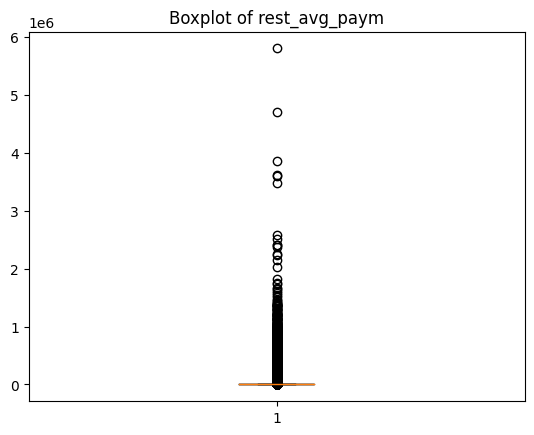

In [113]:
# Boxplot of the column with the most outliers
plt.boxplot(df['rest_avg_paym'])
plt.title('Boxplot of rest_avg_paym')
plt.show()

> The boxplot confirm the previos outliers count. The question here is what is wrong with this values and what to do with them. 

**Potential Causes of Outliers:**

* Errors in Data Entry: Typos or mistakes during data collection or entry could lead to unrealistic values in the account balance.
* Extreme Cases: There might be a small number of clients with exceptionally high or low account balances compared to the majority.
* Data Source Issues: Inconsistency or errors in the way the data was obtained could introduce outliers.
* Inaccurate Feature Definition: The definition of "average salary account balance" itself might be unclear. Does it represent the average salary deposited each month, or the current balance?

In [114]:
df['rest_avg_paym'].describe()

count    3.168670e+05
mean     7.284057e+03
std      4.792909e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.798600e+06
Name: rest_avg_paym, dtype: float64

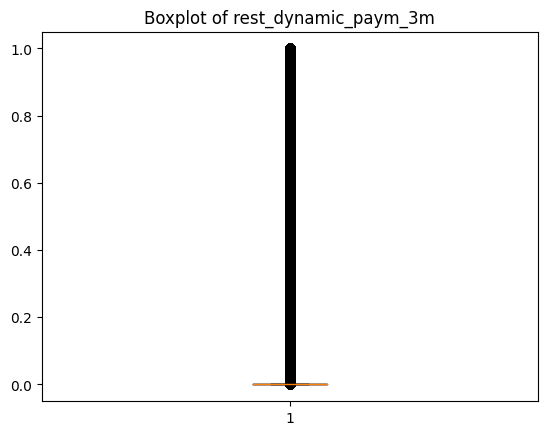

In [115]:
# Boxplot of the column with the most outliers
plt.boxplot(df['rest_dynamic_paym_3m'])
plt.title('Boxplot of rest_dynamic_paym_3m')
plt.show()

In [116]:
df['rest_dynamic_paym_3m'].describe()

count    316867.000000
mean          0.074182
std           0.203010
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: rest_dynamic_paym_3m, dtype: float64

Visualizing missing values in the matrxi

<Axes: >

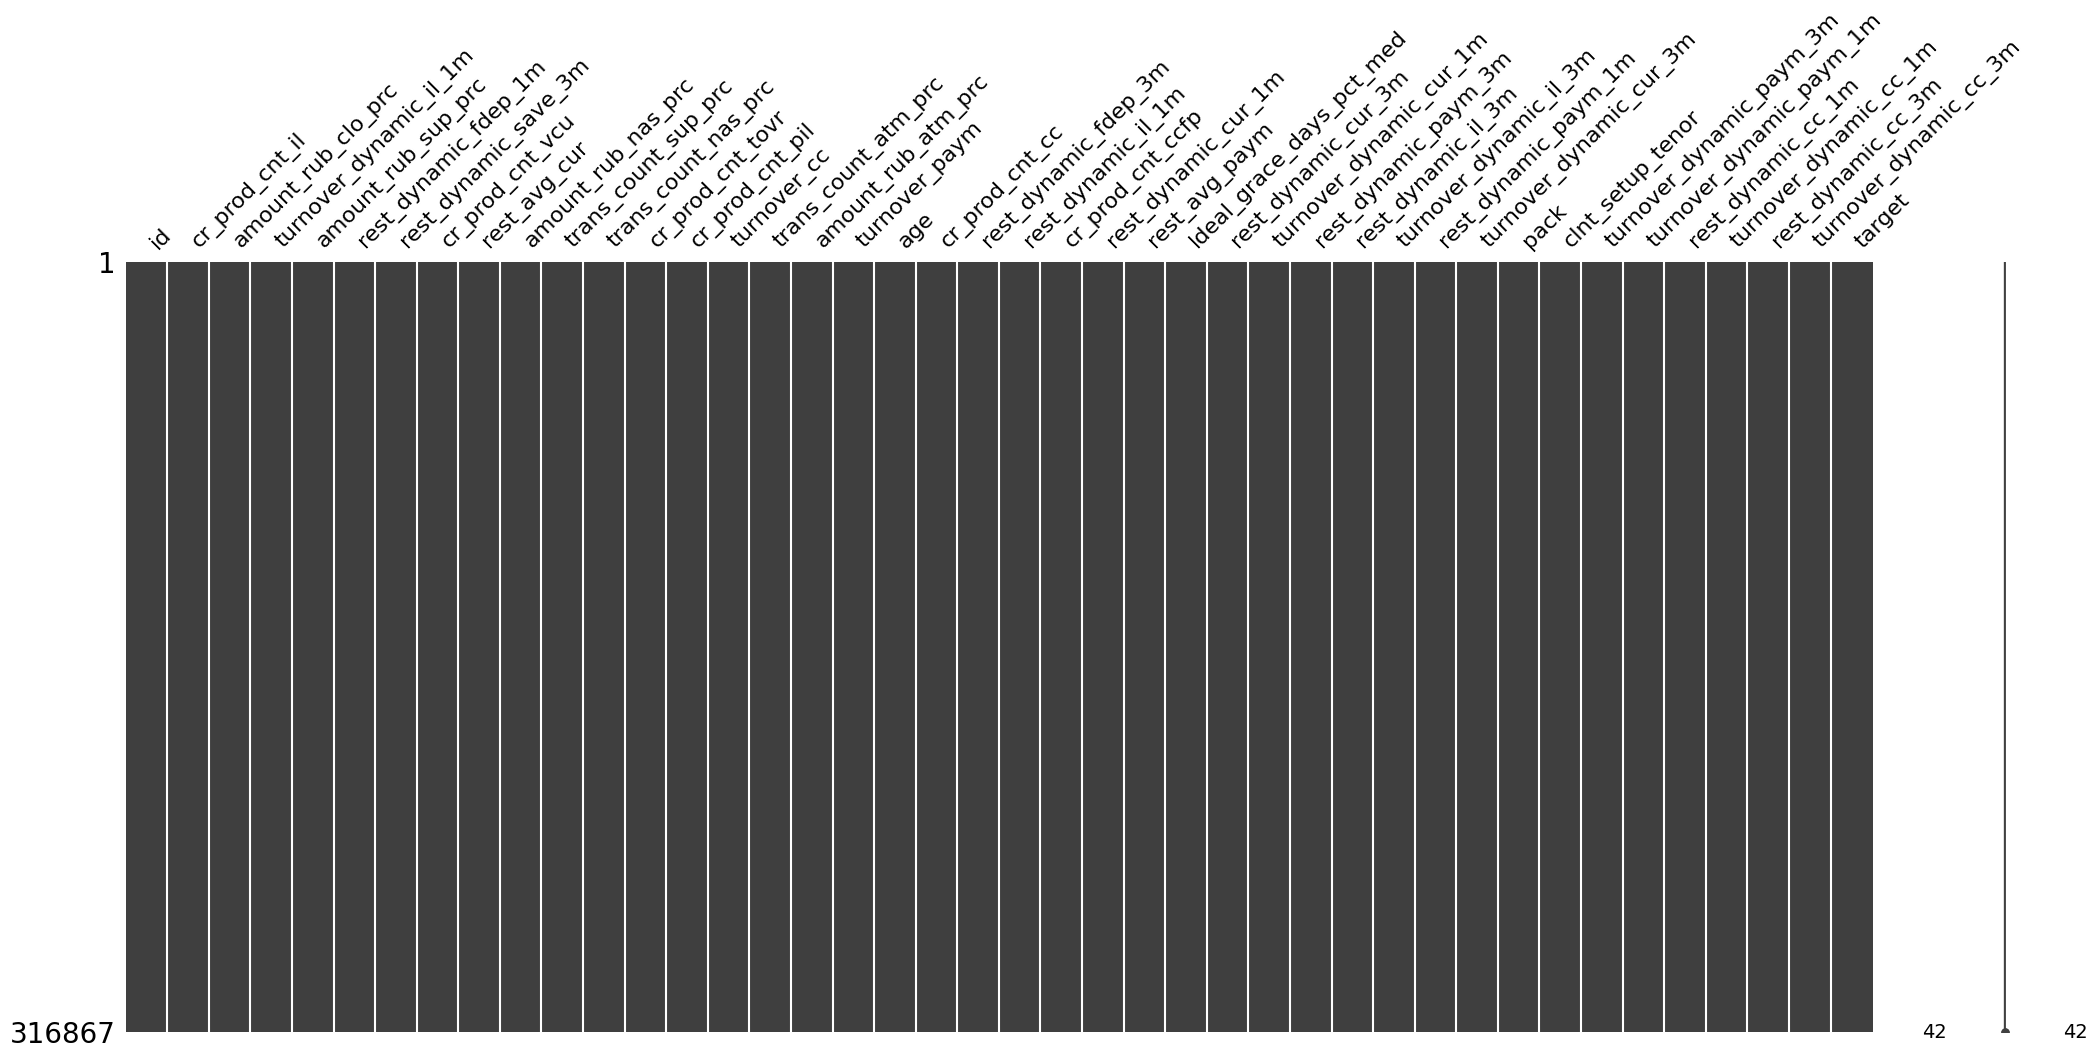

In [117]:
import missingno as msno
msno.matrix(df)

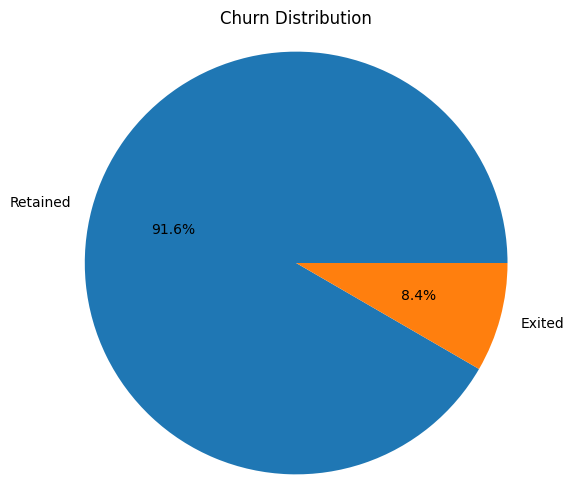

In [118]:
# Define more appealing colors for each category
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Calculate the counts of each category
churn_counts = df['target'].value_counts()

# Create a pie chart with hue
plt.figure(figsize=(6, 6))
plt.pie(churn_counts, labels=['Retained', 'Exited'], autopct='%1.1f%%', colors=colors)
plt.title('Churn Distribution')
# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
plt.show()

The high percentage of retained customers indicates satisfaction with the company's products or services and effective customer retention strategies.

In [119]:
df['age'].unique

<bound method Series.unique of 0         660
1         552
2         420
3         372
4         288
         ... 
355185    516
355186    672
355187    372
355188    540
355189    672
Name: age, Length: 316867, dtype: int64>

In [120]:
# Convert age from months to years
df['age'] /= 12
# Display the DataFrame with the updated age in years
print(df)

            id  cr_prod_cnt_il  amount_rub_clo_prc  turnover_dynamic_il_1m  \
0       146841               0            0.000000                     0.0   
1       146842               0            0.041033                     0.0   
2       146843               0            0.006915                     0.0   
3       146844               0            0.000000                     0.0   
4       146845               0            0.000000                     0.0   
...        ...             ...                 ...                     ...   
355185  590822               0            0.000000                     0.0   
355186  590823               0            0.000000                     0.0   
355187  590825               0            0.041298                     0.0   
355188  590826               0            0.000000                     0.0   
355189  590828               0            0.000000                     0.0   

        amount_rub_sup_prc  rest_dynamic_fdep_1m  rest_dynamic_

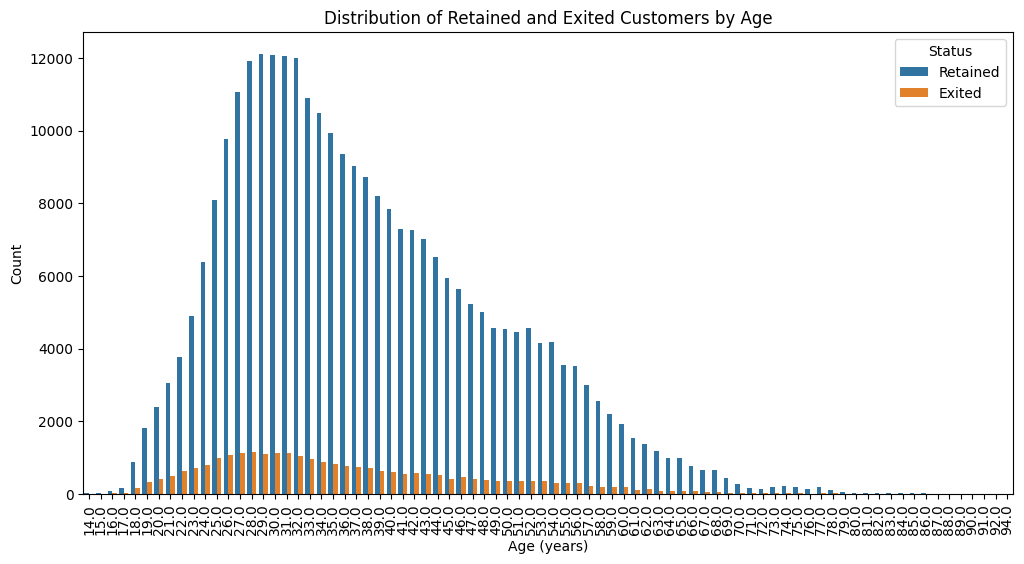

In [121]:
# Create a new column to represent whether the customer is retained or exited
df['status'] = df['target'].map({0: 'Retained', 1: 'Exited'})

# Create bar plot
plt.figure(figsize=(12, 6))
sns.countplot(x='age', hue='status', data=df)
plt.title('Distribution of Retained and Exited Customers by Age')
plt.xlabel('Age (years)')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend(title='Status')  # Add legend for Retained and Exited
plt.show()

>The right-skewed distribution observed for both exited and retained customers indicates a higher proportion of individuals aged 20 to 55 years compared to other age groups in the dataset. Notably, within this age range, there is a higher likelihood of churn observed. Conversely, the higher proportion of older customers staying with the bank implies that they are more likely to remain, suggesting greater retention rates among older age groups.
The observed trend may be influenced by various factors. One possible explanation is that individuals aged 60 years and above may be more inclined to stay with the bank due to factors such as reliance on pension benefits and a reduced likelihood of major life changes, such as career transitions or relocation, compared to other age groups. Additionally, the older demographic may prioritize stability and familiarity in their banking relationships, leading to a higher propensity to remain with the bank.

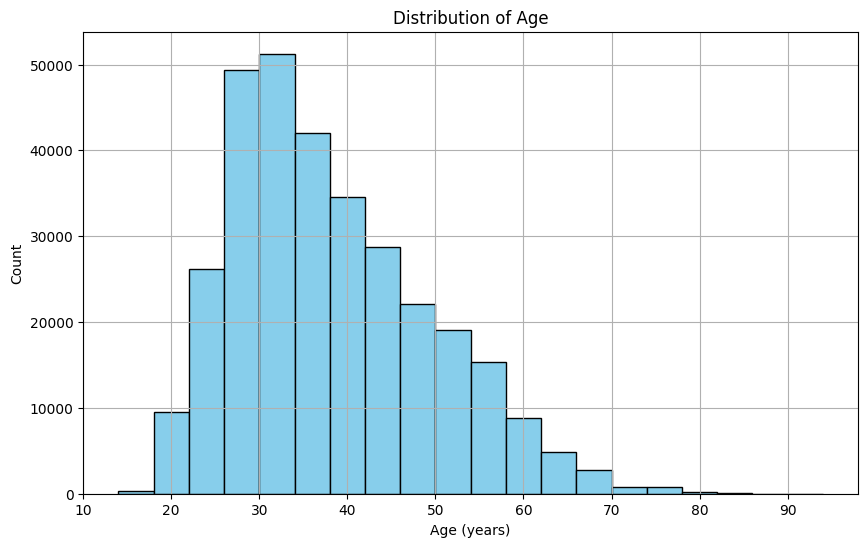

In [122]:
# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(df['age'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Age')
plt.xlabel('Age (years)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


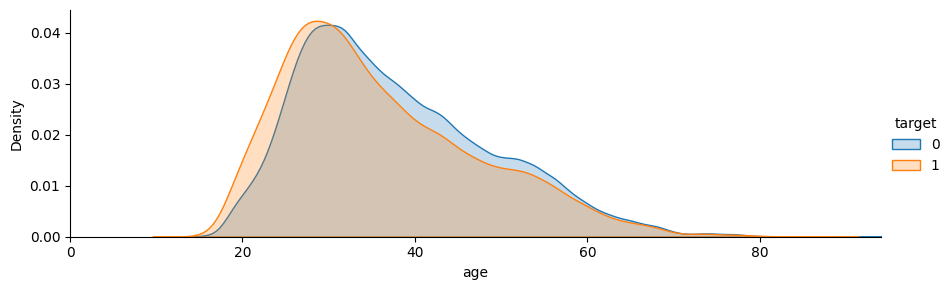

In [123]:
facet = sns.FacetGrid(df, hue="target",aspect=3)
facet.map(sns.kdeplot,"age",fill= True)
facet.set(xlim=(0, df["age"].max()))
facet.add_legend()
plt.show()

>The above distribution shows that customers between 20 to 40 years are more likely to churn.

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


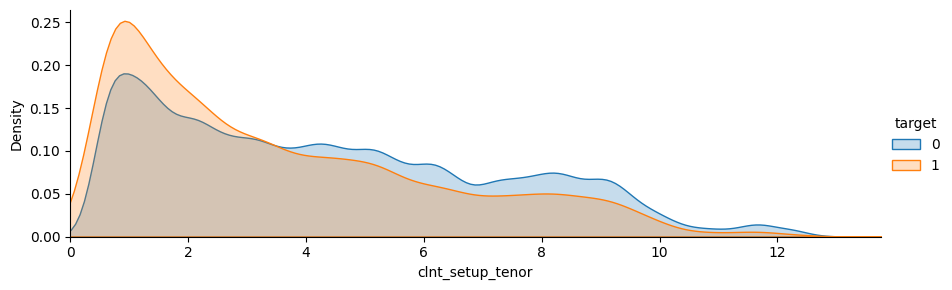

In [124]:
facet = sns.FacetGrid(df, hue="target",aspect=3)
facet.map(sns.kdeplot,"clnt_setup_tenor",fill= True)
facet.set(xlim=(0, df["clnt_setup_tenor"].max()))
facet.add_legend()
plt.show()

>The data suggests that customers are more inclined to churn within the initial months of their association with the bank.

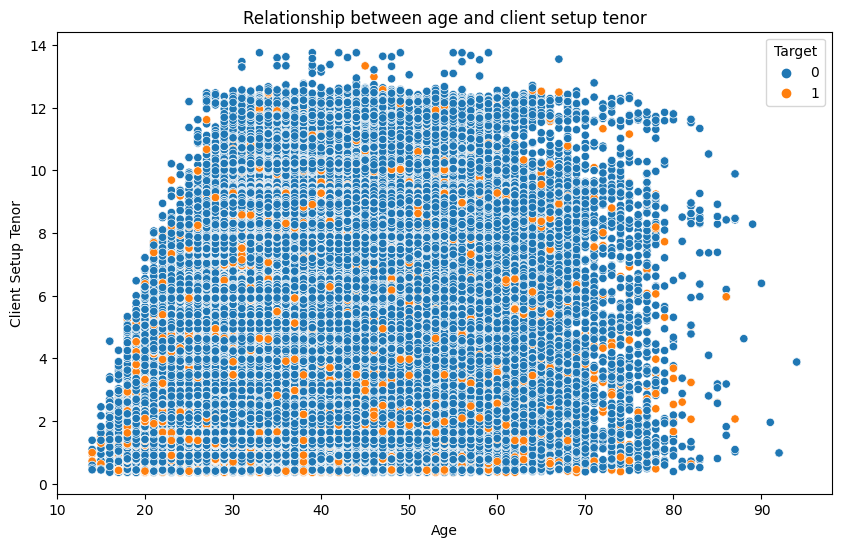

In [125]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='clnt_setup_tenor', hue='target', data=df)
plt.title('Relationship between age and client setup tenor')
plt.xlabel('Age')
plt.ylabel('Client Setup Tenor')
plt.legend(title='Target')
plt.show()


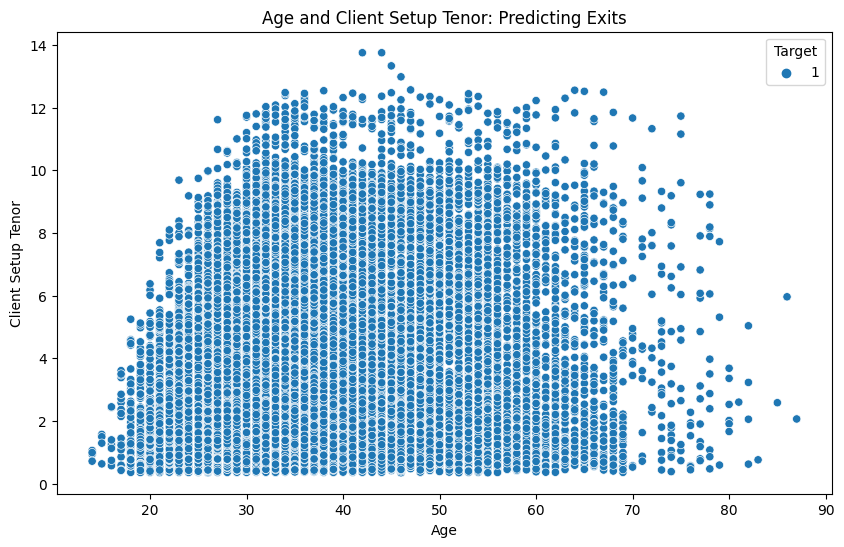

In [126]:
# Filter the DataFrame where target is 1
df_target_1 = df[df['target'] == 1]

# Create scatter plot for age and clnt_setup_tenor with color-coded target (target = 1)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='clnt_setup_tenor', hue='target', data=df_target_1)
plt.title('Age and Client Setup Tenor: Predicting Exits')
plt.xlabel('Age')
plt.ylabel('Client Setup Tenor')
plt.legend(title='Target')
plt.show()


>Individuals aged between 20 to 55 years are inclined to discontinue their banking services within a span of 10 months.
The graph provides valuable insights into our focus on the age group of 20 to 55 years. It illustrates that within this age range, there is a noticeable trend of customers exiting the bank, particularly within 1 to 3 months of setting up their accounts. Beyond the age of 55, we observe fluctuations in the departure pattern, indicating a potential shift in banking behaviors or priorities. This underscores the importance of targeting the 20 to 55 age group in our analysis as it appears to be a critical demographic segment with regards to churn behavior.

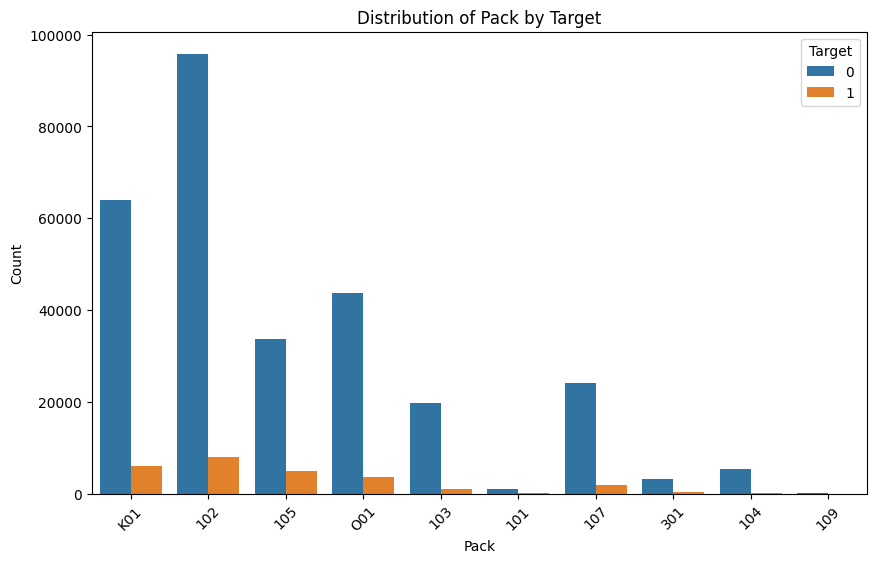

In [127]:
# Create countplot
plt.figure(figsize=(10, 6))
sns.countplot(x='pack', hue='target', data=df)
plt.title('Distribution of Pack by Target')
plt.xlabel('Pack')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Target')  # Add legend for Retained and Exited
plt.show()

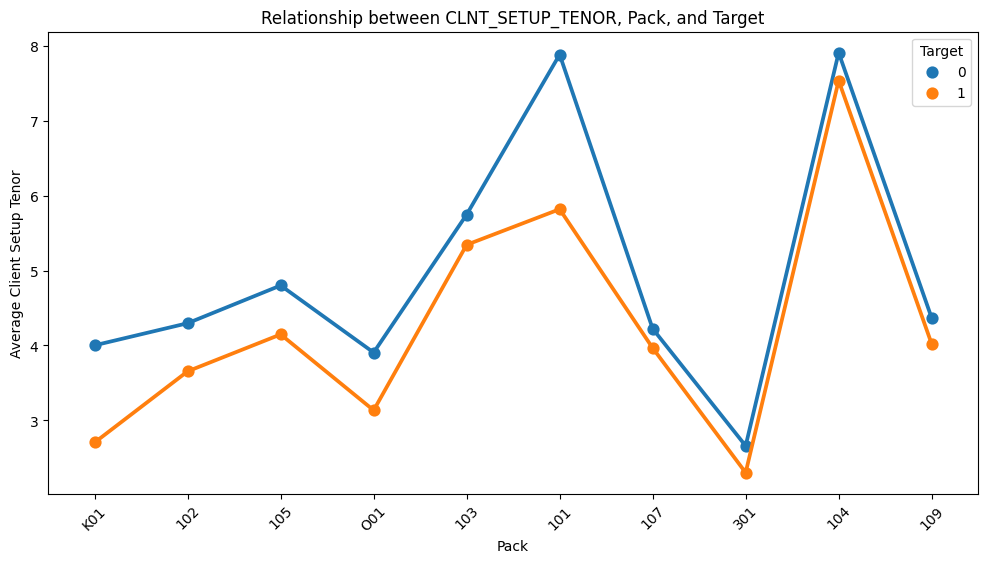

In [128]:
plt.figure(figsize=(12, 6))
sns.pointplot(x='pack', y='clnt_setup_tenor', hue='target', data=df, errorbar=None)
plt.title('Relationship between CLNT_SETUP_TENOR, Pack, and Target')
plt.xlabel('Pack')
plt.ylabel('Average Client Setup Tenor')
plt.xticks(rotation=45)  
plt.legend(title='Target')
plt.show()

>Customers opting for packs K01, O01, and 301 exhibit a higher likelihood of leaving the bank within a three-month period, thereby indicating a significant impact on the retention rate.

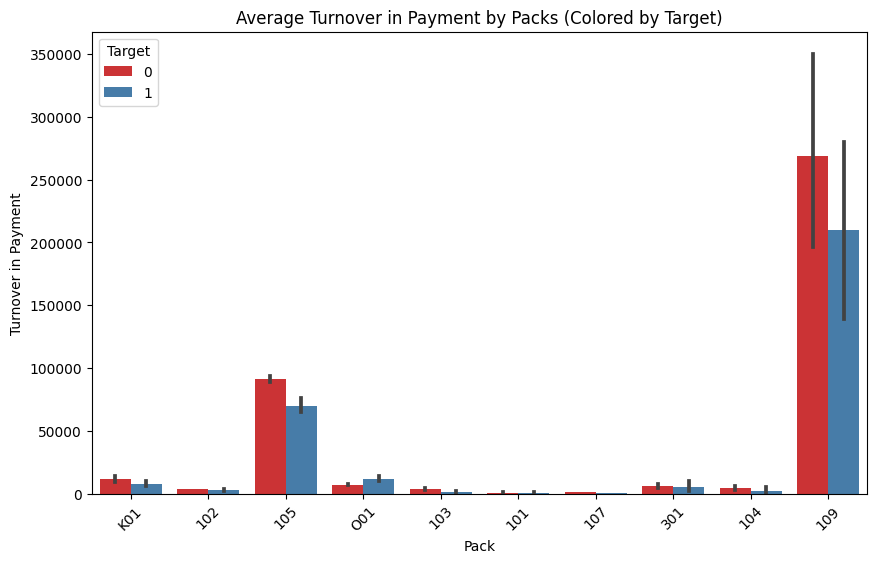

In [129]:
# Create bar plot for turnover_paym with packs colored by target
plt.figure(figsize=(10, 6))
sns.barplot(x='pack', y='turnover_paym', hue='target', data=df, palette='Set1')
plt.title('Average Turnover in Payment by Packs (Colored by Target)')
plt.xlabel('Pack')
plt.ylabel('Turnover in Payment')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Target')
plt.show()

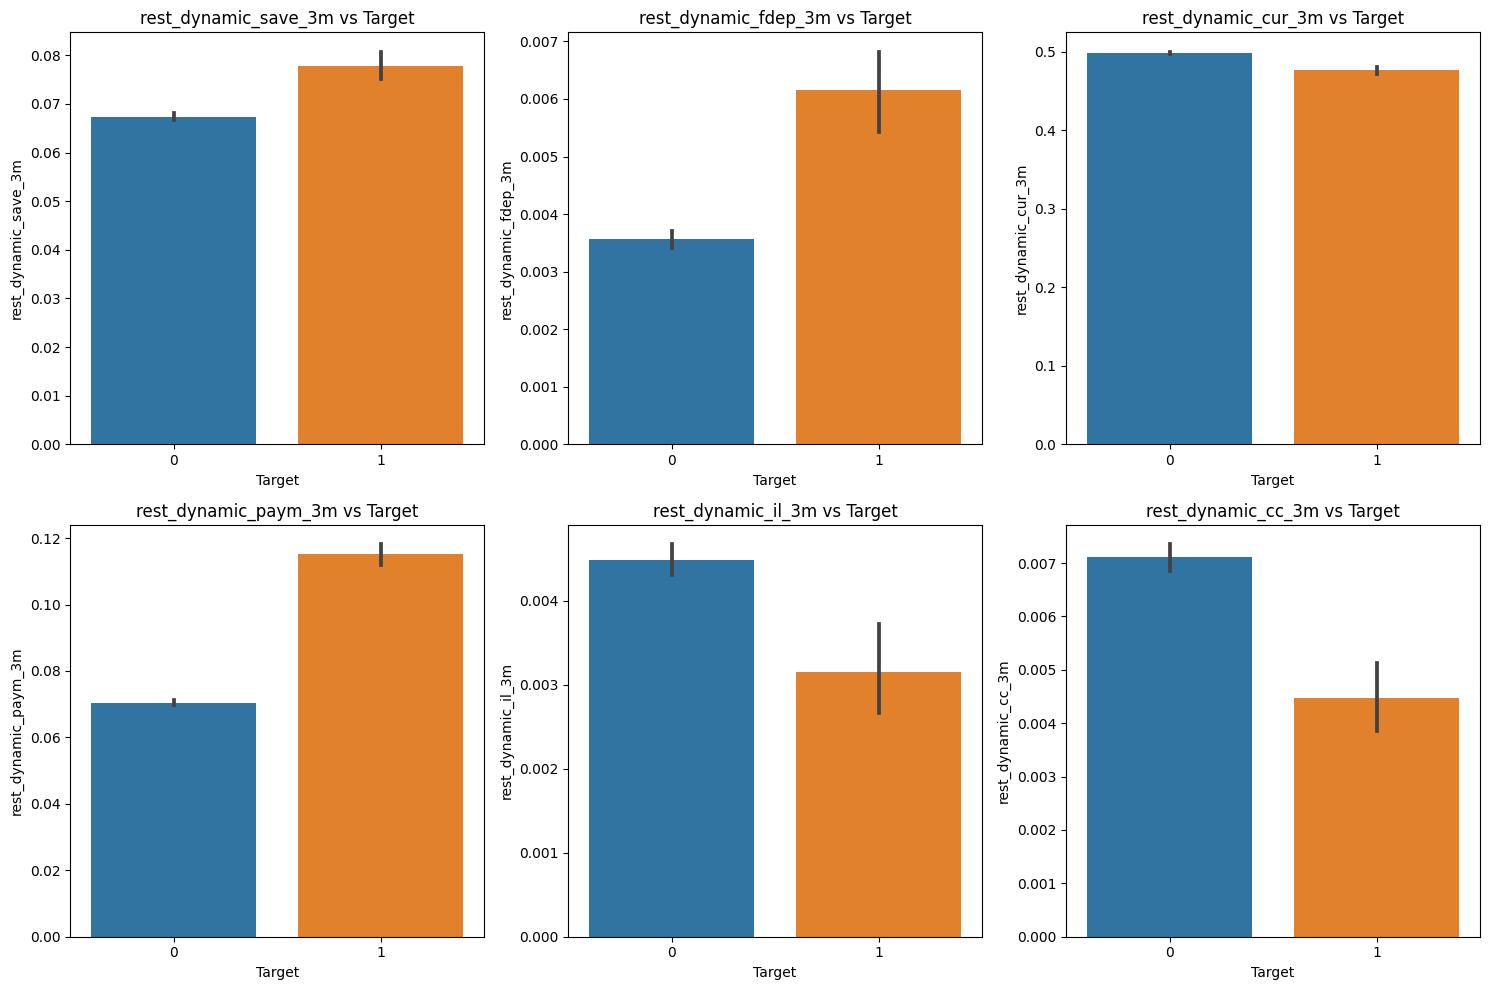

In [130]:
# Define the columns to visualize
columns = ['rest_dynamic_save_3m', 'rest_dynamic_fdep_3m', 'rest_dynamic_cur_3m', 
           'rest_dynamic_paym_3m', 'rest_dynamic_il_3m', 'rest_dynamic_cc_3m']

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Plot each column against target using bar charts
for i, column in enumerate(columns):
    ax = axes[i]  # select the current subplot
    sns.barplot(x='target', y=column, data=df, ax=ax)
    ax.set_title(f'{column} vs Target')
    ax.set_xlabel('Target')
    ax.set_ylabel(column)

plt.tight_layout()
plt.show()

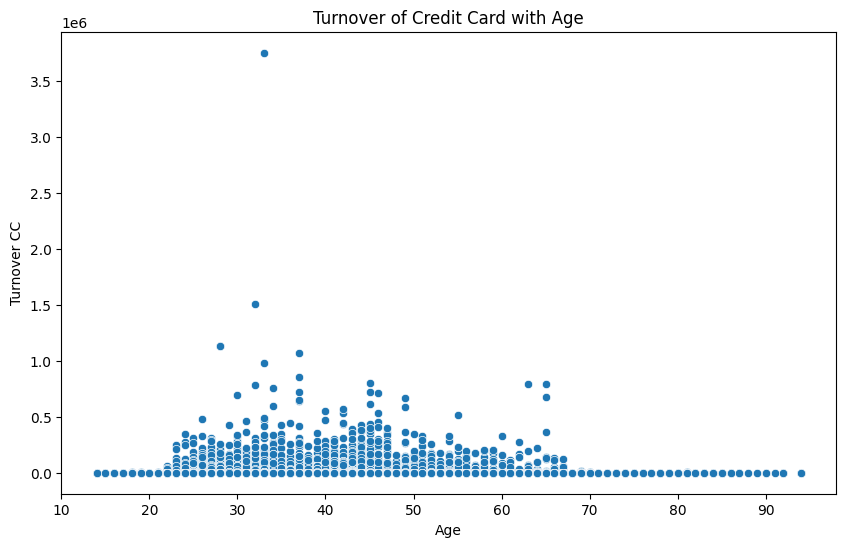

In [131]:
# Create a scatter plot for turnover_cc with age
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='turnover_cc', data=df)
plt.title('Turnover of Credit Card with Age')
plt.xlabel('Age')
plt.ylabel('Turnover CC')
plt.show()

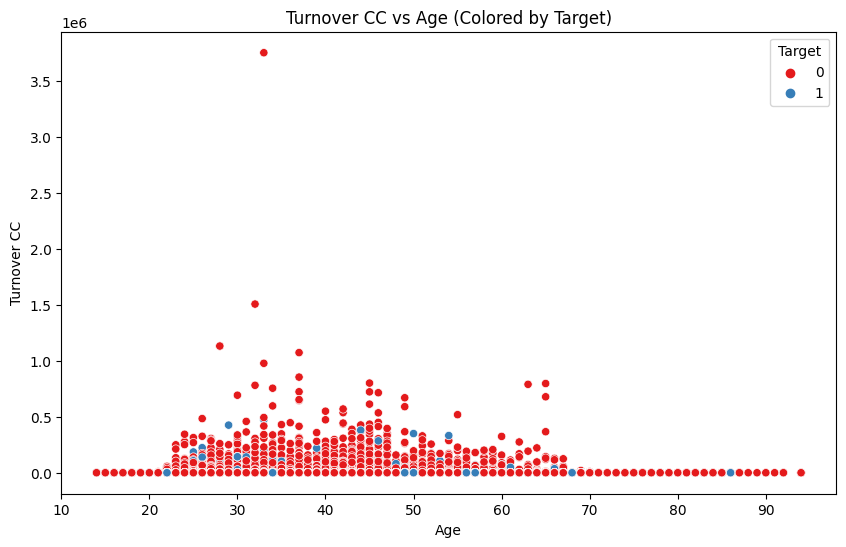

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot for turnover_cc with age, colored by target
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='turnover_cc', hue='target', data=df, palette='Set1')
plt.title('Turnover CC vs Age (Colored by Target)')
plt.xlabel('Age')
plt.ylabel('Turnover CC')
plt.legend(title='Target')
plt.show()


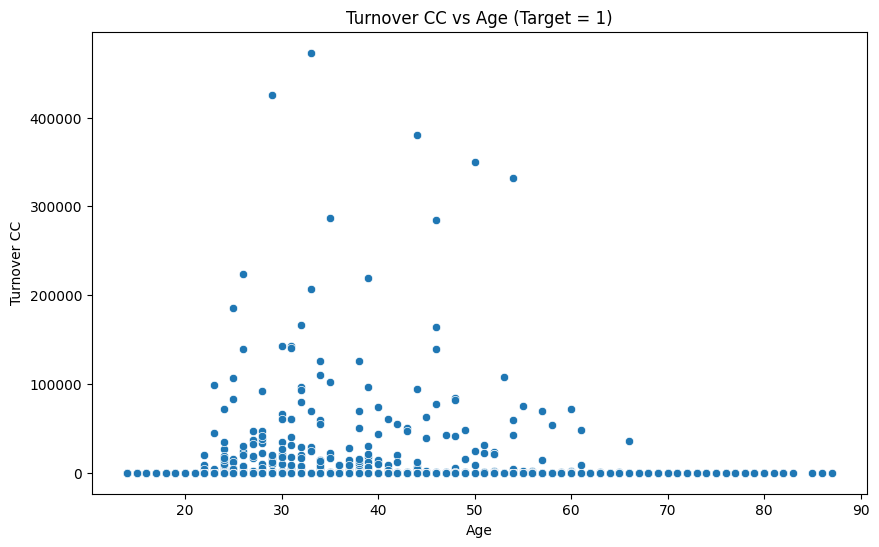

In [133]:
# Filter the DataFrame where target is 1
df_target_1 = df[df['target'] == 1]

# Create a scatter plot for turnover_cc with age, colored by target (target = 1)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='turnover_cc', data=df_target_1)
plt.title('Turnover CC vs Age (Target = 1)')
plt.xlabel('Age')
plt.ylabel('Turnover CC')
plt.show()

>That's an insightful observation. It suggests that there is a correlation between lower turnover amounts and a higher likelihood of churning among customers.

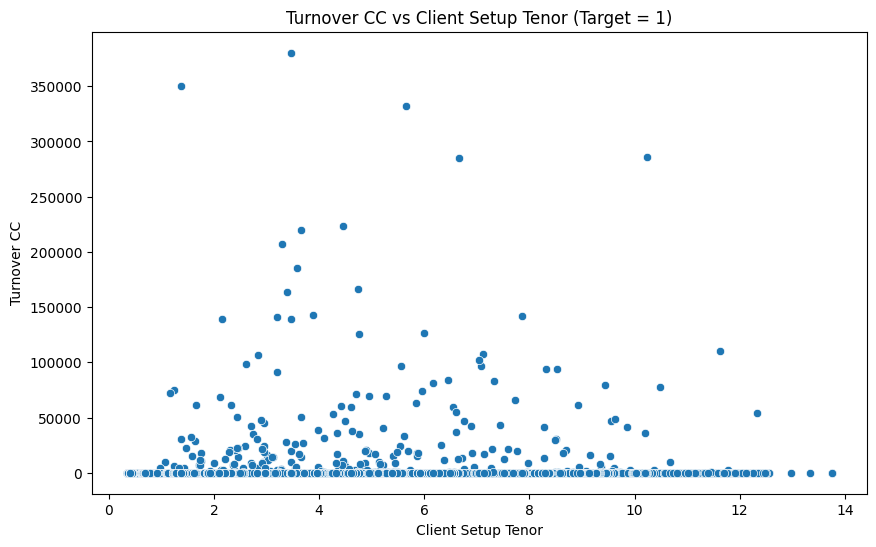

In [134]:
# Filter the DataFrame where target is 1 and turnover_cc is less than 400,000
df_filtered = df[(df['target'] == 1) & (df['turnover_cc'] < 400000)]

# Create a scatter plot for turnover_cc and client_setup_tenor, colored by target (target = 1)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='clnt_setup_tenor', y='turnover_cc', data=df_filtered)
plt.title('Turnover CC vs Client Setup Tenor (Target = 1)')
plt.xlabel('Client Setup Tenor')
plt.ylabel('Turnover CC')
plt.show()

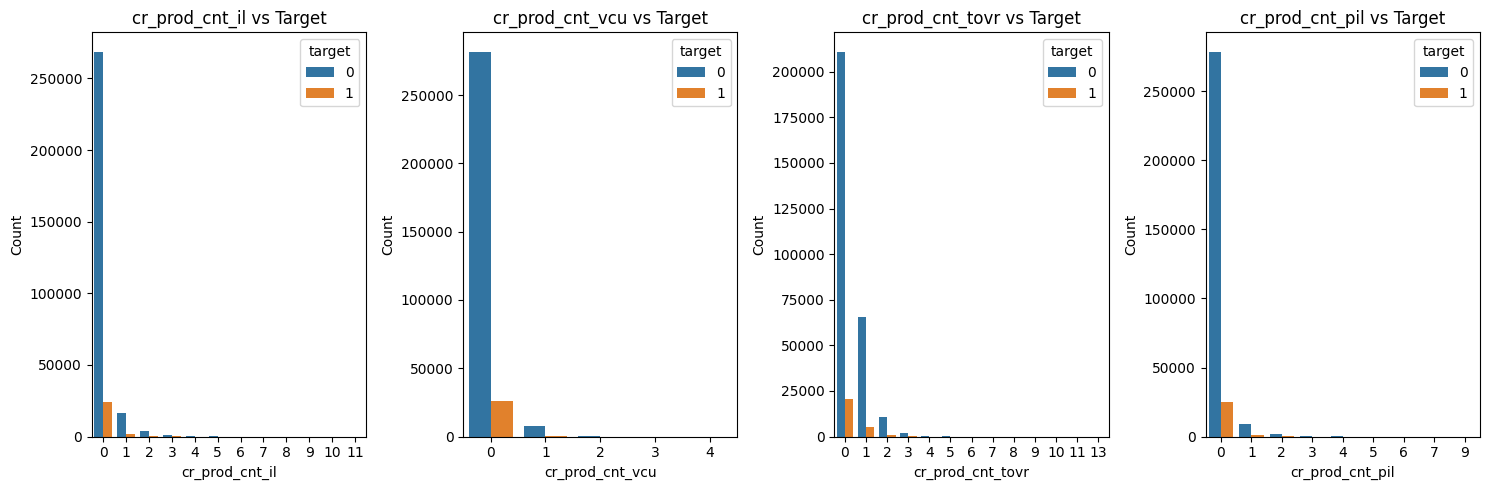

In [135]:
# Define the columns to visualize
columns = ['cr_prod_cnt_il', 'cr_prod_cnt_vcu', 'cr_prod_cnt_tovr', 'cr_prod_cnt_pil']

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=len(columns), figsize=(15, 5))

# Plot each column in a separate subplot
for i, column in enumerate(columns):
    sns.countplot(x=column, hue='target', data=df, ax=axes[i])
    axes[i].set_title(f'{column} vs Target')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

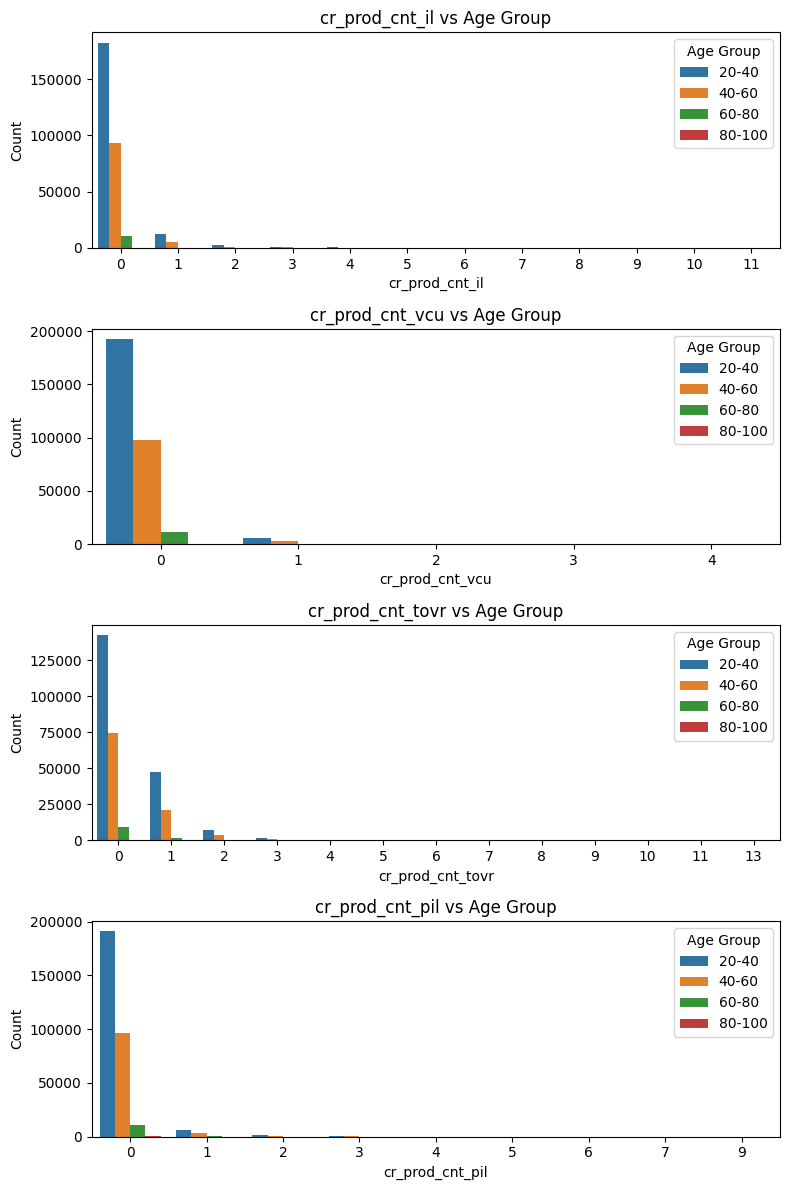

In [136]:
# Create age groups
df['age_group'] = pd.cut(df['age'], bins=[20, 40, 60, 80,100], labels=['20-40', '40-60', '60-80', '80-100'])

# Define the columns to visualize
columns = ['cr_prod_cnt_il', 'cr_prod_cnt_vcu', 'cr_prod_cnt_tovr', 'cr_prod_cnt_pil']

# Set up subplots
fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(8, 12))

# Plot each column with age group as hue
for i, column in enumerate(columns):
    sns.countplot(x=column, hue='age_group', data=df, ax=axes[i])
    axes[i].set_title(f'{column} vs Age Group')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')
    axes[i].legend(title='Age Group')

plt.tight_layout()
plt.show()

Feature Engineering

1. Encoding categorical variables into numerical representations

In [137]:
#Importing the necessary libraries
from sklearn.preprocessing import LabelEncoder

#Initializing the tag encoder
label_encoder = LabelEncoder()

#Applying the encoding to the "pack" column:
df['pack_encoded'] = label_encoder.fit_transform(df['pack'])


In [138]:
df['pack'].value_counts()

pack
102    103917
K01     70070
O01     47308
105     38601
107     25955
103     20732
104      5525
301      3649
101      1028
109        82
Name: count, dtype: int64

In [139]:
df['pack_encoded'].value_counts()

pack_encoded
1    103917
8     70070
9     47308
4     38601
5     25955
2     20732
3      5525
7      3649
0      1028
6        82
Name: count, dtype: int64

In [140]:
#Dropping pack and status features
df.drop(columns=['pack'], inplace=True)
df.drop(columns=['status'], inplace=True)

2. Remove or transform irrelevant or redundant features to streamline the feature space

In [141]:
df['number_products'] = df['cr_prod_cnt_il'].fillna(0) + df['cr_prod_cnt_vcu'].fillna(0) + df['cr_prod_cnt_tovr'].fillna(0) + df['cr_prod_cnt_pil'].fillna(0) + df['cr_prod_cnt_cc'].fillna(0) + df['cr_prod_cnt_ccfp'].fillna(0)

In [142]:
df['number_products'].value_counts()

number_products
0     202077
1      73749
2      23907
3       9763
4       4029
5       1824
6        820
7        340
8        170
9         86
10        49
11        27
12         9
13         7
14         5
16         3
15         2
Name: count, dtype: int64

TARGET (Dependent Variable)

In [143]:
# Frequency of classes of dependent variable
df["target"].value_counts()

target
0    290374
1     26493
Name: count, dtype: int64

In [144]:
# Customers leaving the bank
churn = df.loc[df["target"]==1]

In [145]:
# Customers who did not leave the bank
not_churn = df.loc[df["target"]==0]

In [146]:
# Frequency of not_churn group according to Months of being customers
not_churn["clnt_setup_tenor"].value_counts().sort_values()

clnt_setup_tenor
8.824087       1
7.808077       1
1.507001       1
11.969367      1
10.934421      1
            ... 
1.166667     200
0.916667     203
0.583333     243
0.750000     247
0.666667     250
Name: count, Length: 12506, dtype: int64

In [147]:
# Frequency of churn group according to Months of being customers
churn["clnt_setup_tenor"].value_counts().sort_values()

clnt_setup_tenor
8.961184      1
10.173668     1
8.488184      1
9.660109      1
3.603657      1
             ..
0.571518     28
0.666667     32
0.583333     33
0.750000     34
0.916667     39
Name: count, Length: 7916, dtype: int64

AGE

In [148]:

# examining the age of the not_churn group
not_churn["age"].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])

count    290374.000000
mean         37.798353
std          11.175203
min          14.000000
5%           23.000000
25%          29.000000
50%          36.000000
75%          45.000000
90%          54.000000
95%          58.000000
99%          67.000000
max          94.000000
Name: age, dtype: float64

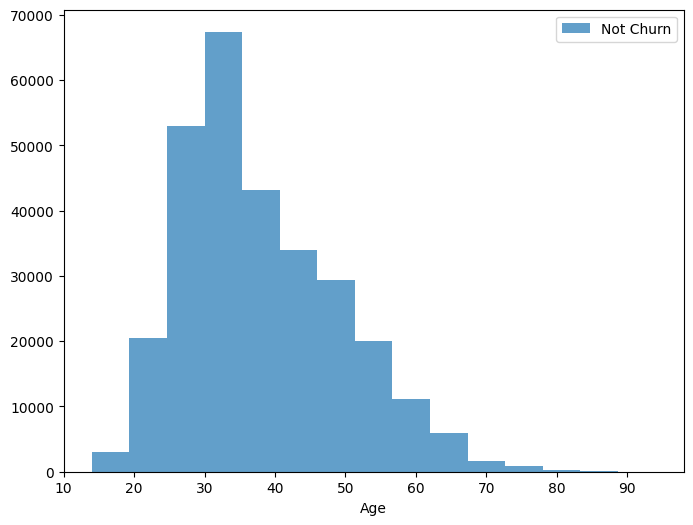

In [149]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
# distribution of the Age for not_churn
pyplot.figure(figsize=(8,6))
pyplot.xlabel('Age')
pyplot.hist(not_churn["age"],bins=15, alpha=0.7, label='Not Churn')
pyplot.legend(loc='upper right')
pyplot.show()

In [150]:
# examining the age of the churn group
churn["age"].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])

count    26493.000000
mean        36.082437
std         11.404333
min         14.000000
5%          21.000000
25%         27.000000
50%         34.000000
75%         43.000000
90%         53.000000
95%         58.000000
99%         67.000000
max         87.000000
Name: age, dtype: float64

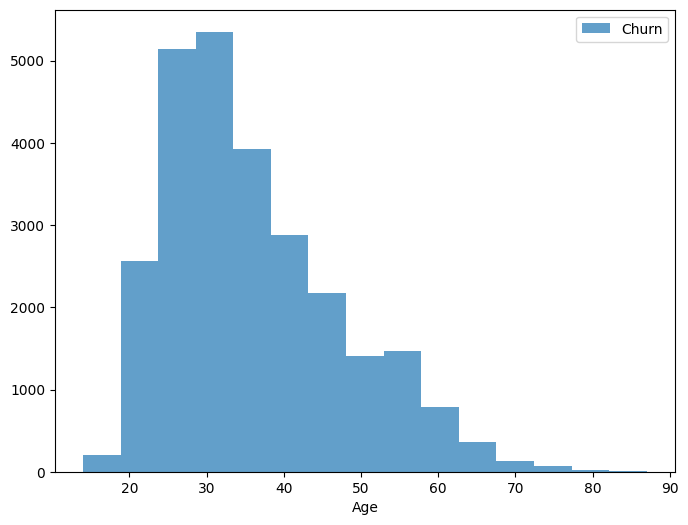

In [151]:
# distribution of the Age for churn
pyplot.figure(figsize=(8,6))
pyplot.xlabel('Age')
pyplot.hist(churn["age"],bins=15, alpha=0.7, label='Churn')
pyplot.legend(loc='upper right')
pyplot.show()

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


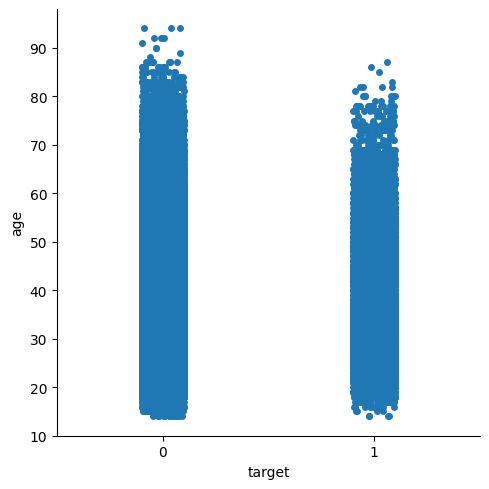

In [152]:
sns.catplot(x='target', y='age', data=df)
plt.show()

In [155]:
#Discretizing age feature 
# Defining category limits
bins = [float('-inf'), 19, 56, float('inf')]  # Límites de las categorías: (-inf, 19], (19, 56], (56, inf)

# Defining label
labels = ['Menor de 20', '20-55 años', 'Mayor de 55']

# Creating a new feature with the categories created 
df['new_age_category'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

# Muestra las primeras filas del DataFrame con la nueva columna
print(df.head())

       id  cr_prod_cnt_il  amount_rub_clo_prc  turnover_dynamic_il_1m  \
0  146841               0            0.000000                     0.0   
1  146842               0            0.041033                     0.0   
2  146843               0            0.006915                     0.0   
3  146844               0            0.000000                     0.0   
4  146845               0            0.000000                     0.0   

   amount_rub_sup_prc  rest_dynamic_fdep_1m  rest_dynamic_save_3m  \
0            0.000000                   0.0              0.541683   
1            0.244678                   0.0              0.000000   
2            0.000000                   0.0              0.000000   
3            0.000000                   0.0              0.005874   
4            0.000000                   0.0              0.000000   

   cr_prod_cnt_vcu   rest_avg_cur  amount_rub_nas_prc  trans_count_sup_prc  \
0                0  156067.339800                 0.0             0.

In [157]:
print(df['new_age_category'].unique())
print(df['new_age_category'].value_counts())

['20-55 años', 'Mayor de 55', 'Menor de 20']
Categories (3, object): ['Menor de 20' < '20-55 años' < 'Mayor de 55']
new_age_category
20-55 años     290103
Mayor de 55     25390
Menor de 20      1374
Name: count, dtype: int64


Number of products

In [158]:
# Frequency of not_churn group according to NumOfProducts
not_churn["number_products"].value_counts().sort_values()

number_products
15         1
16         2
14         4
13         7
12         8
11        25
10        42
9         80
8        160
7        308
6        758
5       1685
4       3710
3       9069
2      22246
1      67946
0     184323
Name: count, dtype: int64

In [159]:

# Frequency of not_churn group according to NumOfProducts
not_churn["number_products"].value_counts().sort_values()

number_products
15         1
16         2
14         4
13         7
12         8
11        25
10        42
9         80
8        160
7        308
6        758
5       1685
4       3710
3       9069
2      22246
1      67946
0     184323
Name: count, dtype: int64

In [160]:
# Frequency of churn group according to NumOfProducts
churn["number_products"].value_counts().sort_values()

number_products
12        1
14        1
15        1
16        1
11        2
9         6
10        7
8        10
7        32
6        62
5       139
4       319
3       694
2      1661
1      5803
0     17754
Name: count, dtype: int64

3. Standarization and normalization

In [164]:
df['clnt_setup_tenor_years'] = df['clnt_setup_tenor'] * 12

In [165]:
# normalizing tenure in relation to age, potentially offering a fresh perspective on customer retention based on age.
df["new_setup_tenor"] = df["clnt_setup_tenor_years"]/df["age"]
df.head()

,id,cr_prod_cnt_il,amount_rub_clo_prc,turnover_dynamic_il_1m,amount_rub_sup_prc,rest_dynamic_fdep_1m,rest_dynamic_save_3m,cr_prod_cnt_vcu,rest_avg_cur,amount_rub_nas_prc,trans_count_sup_prc,trans_count_nas_prc,cr_prod_cnt_tovr,cr_prod_cnt_pil,turnover_cc,trans_count_atm_prc,amount_rub_atm_prc,turnover_paym,age,cr_prod_cnt_cc,rest_dynamic_fdep_3m,rest_dynamic_il_1m,cr_prod_cnt_ccfp,rest_dynamic_cur_1m,rest_avg_paym,ldeal_grace_days_pct_med,rest_dynamic_cur_3m,turnover_dynamic_cur_1m,rest_dynamic_paym_3m,rest_dynamic_il_3m,turnover_dynamic_il_3m,rest_dynamic_paym_1m,turnover_dynamic_cur_3m,clnt_setup_tenor,turnover_dynamic_paym_3m,turnover_dynamic_paym_1m,rest_dynamic_cc_1m,turnover_dynamic_cc_1m,rest_dynamic_cc_3m,turnover_dynamic_cc_3m,target,age_group,pack_encoded,number_products,new_age_category,age_months,new_setup_tenor,clnt_setup_tenor_years
0,146841,0,0.000000,0.0,0.000000,0.0,0.541683,0,156067.339800,0.0,0.000000,0.0,0,0,0.0,1.000000,1.000000,0.0,55.0,0,0.0,0.0,0,0.134651,0.0,0.0,0.474134,0.131910,0.0,0.0,0.0,0.0,0.442285,1.593023,0.0,0.0,0.0,0.0,0.0,0.0,0,40-60,8,0,20-55 años,660.0,0.347569,19.116275
1,146842,0,0.041033,0.0,0.244678,0.0,0.000000,0,4278.845817,0.0,0.454545,0.0,0,0,0.0,0.109091,0.410691,0.0,46.0,0,0.0,0.0,0,0.239365,0.0,0.0,0.384264,0.101934,0.0,0.0,0.0,0.0,0.515876,1.587647,0.0,0.0,0.0,0.0,0.0,0.0,0,40-60,1,0,20-55 años,552.0,0.414169,19.051759
2,146843,0,0.006915,0.0,0.000000,0.0,0.000000,0,112837.062800,0.0,0.000000,0.0,0,0,0.0,0.810811,0.925140,0.0,35.0,0,0.0,0.0,0,0.084341,0.0,0.0,0.336136,0.121041,0.0,0.0,0.0,0.0,0.522833,1.587647,0.0,0.0,0.0,0.0,0.0,0.0,0,20-40,1,0,20-55 años,420.0,0.544336,19.051759
3,146844,0,0.000000,0.0,0.000000,0.0,0.005874,0,42902.902880,0.0,0.000000,0.0,0,0,0.0,1.000000,1.000000,0.0,31.0,0,0.0,0.0,0,0.005659,0.0,0.0,0.019648,0.000005,0.0,0.0,0.0,0.0,0.000189,1.583333,0.0,0.0,0.0,0.0,0.0,0.0,0,20-40,8,0,20-55 años,372.0,0.612903,19.000000
4,146845,0,0.000000,0.0,0.000000,0.0,0.000000,0,71906.476530,0.0,0.000000,0.0,0,0,0.0,1.000000,1.000000,0.0,24.0,0,0.0,0.0,0,0.166946,0.0,0.0,0.556935,0.177869,0.0,0.0,0.0,0.0,0.593648,1.583333,0.0,0.0,0.0,0.0,0.0,0.0,0,20-40,1,0,20-55 años,288.0,0.791667,19.000000


In [170]:
#Dropping redundant features 

#age and new setup tenor in years
df.drop(['age', 'clnt_setup_tenor_years'], axis=1, inplace=True)

KeyError: "['age', 'clnt_setup_tenor_years'] not found in axis"

In [171]:
age_columns = [col for col in df.columns if 'age' in col]
print(age_columns)

['age_group', 'new_age_category', 'age_months']


In [173]:
#Dropping age_group and age_months 
df.drop(['age_group', 'age_months'], axis=1, inplace=True)

In [177]:
# Filtrar las columnas que contienen la palabra "age" en su nombre
turnover_columns = [col for col in df.columns if 'turnover' in col]

# Mostrar las columnas encontradas
print(turnover_columns)

['turnover_dynamic_il_1m', 'turnover_cc', 'turnover_paym', 'turnover_dynamic_cur_1m', 'turnover_dynamic_il_3m', 'turnover_dynamic_cur_3m', 'turnover_dynamic_paym_3m', 'turnover_dynamic_paym_1m', 'turnover_dynamic_cc_1m', 'turnover_dynamic_cc_3m']


In [180]:
# Sum the values of all turnover columns
df['total_turnover'] = df[['turnover_dynamic_il_1m', 'turnover_cc', 'turnover_paym']].sum(axis=1)

print(df[['total_turnover']].count())


total_turnover    316867
dtype: int64


In [182]:
# Discretizing the new total_turnover feature using pd.qcut() with 'duplicates' set to 'drop'
df['total_turnover_category'] = pd.qcut(df['total_turnover'], 6, labels=False, duplicates='drop')


In [183]:
# Drop the 'total_turnover' column from the DataFrame
df.drop(columns=['total_turnover'], inplace=True)


4. Standarizing 

In [184]:
# Scaling features using statistics that are robust to outliers.

def robust_scaler(variable):
    if variable.dtype == 'object':  # If the variable is of type 'object', it's likely a label encoded column
        return variable
    else:  # If the variable is numeric, apply robust scaling
        var_median = variable.median()
        quartile1 = variable.quantile(0.25)
        quartile3 = variable.quantile(0.75)
        interquantile_range = quartile3 - quartile1
        if int(interquantile_range) == 0:
            quartile1 = variable.quantile(0.05)
            quartile3 = variable.quantile(0.95)
            interquantile_range = quartile3 - quartile1
            if int(interquantile_range) == 0:
                quartile1 = variable.quantile(0.01)
                quartile3 = variable.quantile(0.99)
                interquantile_range = quartile3 - quartile1
                z = (variable - var_median) / interquantile_range
                return round(z, 3)

            z = (variable - var_median) / interquantile_range
            return round(z, 3)
        else:
            z = (variable - var_median) / interquantile_range
        return round(z, 3)
